In [1]:
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
img_size = 100

In [3]:
def get_pixels(image_path):
    if image_path.endswith("png"):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_png(img, channels=3)
        
        height = tf.shape(img)[0]
        width = tf.shape(img)[1]
        max_dim = tf.reduce_max([height, width])
        pad_height = (max_dim - height) // 2
        pad_width = (max_dim - width) // 2

        img = tf.image.pad_to_bounding_box(img, pad_height, pad_width, max_dim, max_dim)
        
        img = tf.image.resize(img, [img_size, img_size])
        img = tf.cast(img, tf.float32) / 255.0
        
        if None not in img:
            return img

In [4]:
uninf_filenames = os.listdir("cell_images/Uninfected")
uninf_data = []
for fn in uninf_filenames:
    uninf_data.append([get_pixels(f"cell_images/Uninfected/{fn}"), 0])

inf_filenames = os.listdir("cell_images/Parasitized")
inf_data = []
for fn in inf_filenames:
    inf_data.append([get_pixels(f"cell_images/Parasitized/{fn}"), 1])

data = uninf_data + inf_data

random.shuffle(data)

In [5]:
for i in data:
    if None in i:
        data.remove(i)

In [6]:
train_size = int(len(data) * 0.8)
val_size = train_size+int(len(data) * 0.17)

In [7]:
train_images = tf.convert_to_tensor([i[0] for i in data[:train_size]])
train_labels = tf.convert_to_tensor([int(i[1]) for i in data[:train_size]])

In [8]:
val_images = tf.convert_to_tensor([i[0] for i in data[train_size:val_size]])
val_labels = tf.convert_to_tensor([int(i[1]) for i in data[train_size:val_size]])

In [9]:
test_images = tf.convert_to_tensor([i[0] for i in data[val_size:]])
test_labels = tf.convert_to_tensor([int(i[1]) for i in data[val_size:]])

In [10]:
model = Sequential([
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))

Epoch 1/3
689/689 [==============================] - 15s 22ms/step - loss: 0.1440 - accuracy: 0.9550 - val_loss: 0.1462 - val_accuracy: 0.9492
Epoch 2/3
689/689 [==============================] - 15s 21ms/step - loss: 0.1376 - accuracy: 0.9553 - val_loss: 0.1424 - val_accuracy: 0.9522
Epoch 3/3
689/689 [==============================] - 15s 22ms/step - loss: 0.1325 - accuracy: 0.9572 - val_loss: 0.1279 - val_accuracy: 0.9609


In [20]:
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Overall accuracy: {round(accuracy*100, 2)}%")

26/26 [==============================] - 0s 8ms/step
Overall accuracy: 94.32%


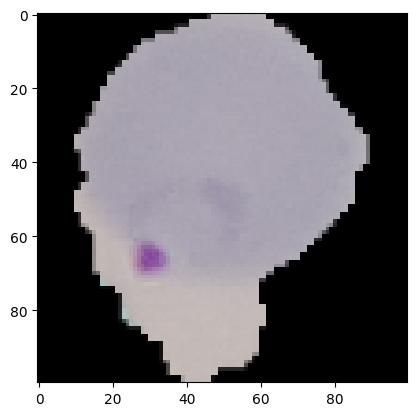

Actual: 1
Prediction: [1]


In [21]:
rndm = random.randrange(len(test_labels))
plt.imshow(test_images[rndm])
plt.show()
print("Actual:", int(test_labels[rndm]))
print("Prediction:", predicted_labels[rndm])

In [22]:
model.save('parameters.keras')